# Deep Computer Vision w/ CNNs

Convolutional Neural Nets based off human visual vortex

## The Architecture of the Visual Cortex

Many neurons in cortex have a small local receptive field -> they react only to stimuli in a certain part of your visual field

Some neurons only react to lines oriented horizontally or vertically, some of bigger fields, some react to complex patterns of other neuron firings

Yann LeCun et al introduced convolutional layers and pooling layers in 1998

## Convolutional Layers

Neurons in the convolutional layer do not connect to every single pixel from the input image, but rather to their receptive fields

The next convolutional layer only looks at a subset (field) of the first one

A neuron at row i, col j is connected to outputs of previous layer located in rows i to i + $f_h-1$, cols j to j + $f_w-1$ whre fh and fw are the height and width of the receptive field

To make sure each layer has the same shape, common to add 0's around inputs

Can also go big input -> small output by spacing out the receptive fields. "Stride" is the horizontal/vertical step size from one field to the next

row i, col j connected to i x $s_h$ to i x $s_h + f_h - 1 $, j x $s_w$ to j x $s_w + f_w - 1 $
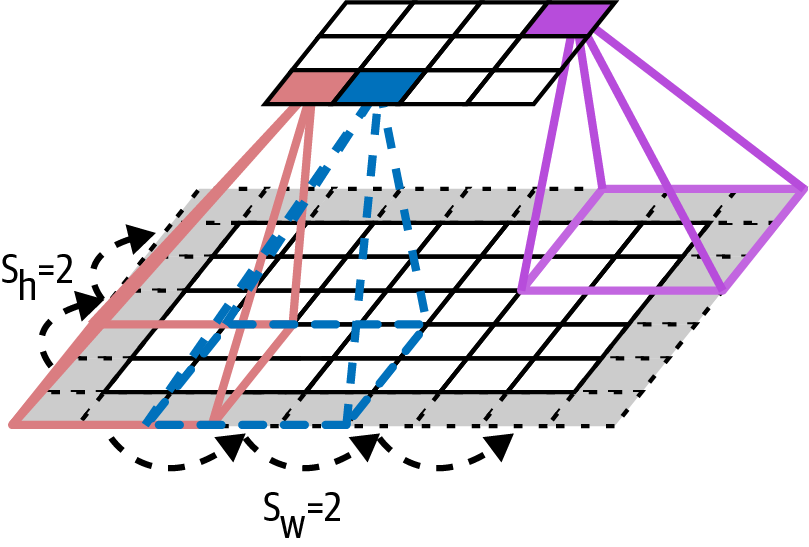

### Filters
also called weights, convolution kernels, kernels

Neuron weights can be rep'd as a small img the size of field

A 7x7 matrix full of zeroes except center column lined with 1's ignores everything except vertical pixels

This "enhances" vertical lines in the original image

A layer full of neurons w/ same filter outputs a feature map, which can show you which parts of the img a filter is highlighting

### Stacking Feature Maps

Each convolutional layer has multiple filters, outputs one feature map per filter

One neuron per pixel in each feature map, and all neurons in the same feature map have the same kernel and bias term

Image inputs are composed of sublayers -> one per color channel (RGB)

The output of one neuron in a convolutional layer :

$$ z_{i,j,k} = b_k + \sum_{\mu=0}^{f_h-1} + \sum_{v =0}^{f_w-1} + \sum_{k^`=0}^{f_{n^`-1}} x_{i^`, j^`, k^`} * w_{\mu, v, k^`, k} $$

Where:
- $i^`/j^` = i/j * s_{h/w} + \mu/v$
- $z_{i,j,k}$ is the output in row i, col j, feature map k of convolutional layer l
- sh, sw is strides, fh and fw are width and height, fn` is the n feature maps in prev layer
- $x_{i^`, j^`, k^`}$ is the output of the previous layer, row i, col j, feature map k
- b_k is this feature map's bias term
- $w_{\mu, v, k^`, k}$ is the connection weight btwn neuron in feature map k, and its input located at u,v, at feature map k`

### Convolutional Layers in Pytorch

In [1]:
import numpy as np
import torch
from sklearn.datasets import load_sample_images

samples = np.stack(load_sample_images()["images"])
samples = torch.tensor(samples, dtype=torch.float32) / 255
samples.shape

torch.Size([2, 427, 640, 3])

2 images, 427 x 640 pixels, 3 color channels. 

Pytorch expects color before height and width:

In [2]:
samples_permuted = samples.permute(0,3,1,2)
samples_permuted.shape

torch.Size([2, 3, 427, 640])

In [3]:
# center cropping

import torchvision
import torchvision.transforms.v2 as T

cropped_imgs = T.CenterCrop((70,120))(samples_permuted)
cropped_imgs.shape

torch.Size([2, 3, 70, 120])

In [5]:
import torch.nn as nn

# 3 input color channels
# 32 filters
# 7x7 kernels
conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7)
fmaps = conv_layer(cropped_imgs)
fmaps.shape
# now: 32 channels, height and width - 6
# no zero - padding by default

torch.Size([2, 32, 64, 114])

In [6]:
# default padding = "valid"
# set padding = "same" to ensure enough zeroes on all sides

conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, padding="same")
fmaps = conv_layer(cropped_imgs)
fmaps.shape

torch.Size([2, 32, 70, 120])

keep in mind if you set stride > 1 (the default) the output will be smaller than the input

you also cannot use padding=same and stride>1 because then you have some neurons that are looking at more zeroes than necessary

In [ ]:
conv_layer.weight.shape
# [output channels, input channels, kernel height, kernel width]

# bias shape is 32, one bias per filter

torch.Size([32, 3, 7, 7])

Important: image height and width dont show up in the weights!

This works because all neurons in each feature map have the exact same weights, so it does not matter how big the input is as long as its at least the size of the kernel

Need to add an activation function after a convolutional layer.

Bias and weight are randomly initialized using uniform distribution. SHOULD CHANGE THIS based on activation (ie He w/ Relu), and you can just zero the biases

## Pooling Layers

goal: subsample the input img to reduce complexity

Each neuron is connected to a small rectangle of inputs, and you define its size, stride, padding just like in convolutional layer

But the pooling layer just uses a simple aggregation, like mean or max, to decide on its output. Typically does each input channel independently, so you take the max red, max green, and max blue over some subregion (say 2x2, and it outputs a 1/2 sized image)

Invariance : a small translational change in the input can have no change on the pooling output

Max pooling gives you some small amount of translational/rotational invariance so these small shifts in the inputs don't mess with the outputs

### Pooling Layers w/ Pytorch

In [10]:
max_pool = nn.MaxPool2d(kernel_size=2) #2x2
# strides default to kernel size (so no overlap)
# default padding is 0 ("valid")

# You can also avg pool, but its less common
# Max pooling is computationally cheaper and tends to keep only the important features


It is also possible to pool along the depth dimension, which could help a CNN learn to be invariant to various features

In [12]:
# pooling on depth
import torch.nn.functional as F

class DepthPool(torch.nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, inputs):
        batch, channels, height, width = inputs.shape
        Z = inputs.view(batch, channels, height*width) # this merges spatial dimensions
        Z = Z.permute(0,2,1)
        Z = F.max_pool1d(Z, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        Z = Z.permute(0,2,1)
        return Z.view(batch, -1, height, width) # undo merge

What this does:
- merge height and width dims to one dimension
- switch channels and spatial dim
- max_pools along the 32 channels -> output is 8 channels
- switch back channels and spatial

Modern architectures also use a global avg pooling layer, which computes the mean of each feature map. Very destructive, 1 number per map

To make this:

In [15]:
global_avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
output = global_avg_pool(cropped_imgs)
# you could also just use a torch.mean on dims 2,3 to get the same output

## CNN Architectures

typical: stack a few convolutional layers (+relu after each), then pooling, then a few convolutional, then a pool, etc.

img gets smaller spatially, but deeper w/ more feature maps

at the top of the network, a regular neural net is used to get class probabilities

Generally: prefer 2 layers with 3x3 kernels to 1 layer w/ 5x5
- first layer should have a "large" 5x5, 7x7 kernel, w/ stride of 2+

In [18]:
# A CNN for FashionMNIST:

from functools import partial
device = "cuda"
DefaultConv = partial(nn.Conv2d, kernel_size=3, padding="same")
model = nn.Sequential(
    DefaultConv(in_channels=1, out_channels=64, kernel_size=7), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    DefaultConv(in_channels=64, out_channels=128), nn.ReLU(),
    DefaultConv(in_channels=64, out_channels=128), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    DefaultConv(in_channels=128, out_channels=256), nn.ReLU(),
    DefaultConv(in_channels=256, out_channels=256), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(in_features=2304, out_features=128), nn.ReLU(),
    nn.Dropout(.5),
    nn.Linear(in_features=128, out_features=64), nn.ReLU(),
    nn.Dropout(.5),
    nn.Linear(in_features=64, out_features=10),
).to(device)

Steps in this model:
1) Convolutional layer that has 64 "large" filters. 1 input channel since grayscale
2) Max pool to reduce img size by 2
3) Two repetitions of: 2x convolution, 1x pool
    - Note: number of filter layers doubles as we go thru cnn
    - Idea: capturing more and more complex patterns
    - generally, can double filters after halving size w/ pooling since no memory explosion
4) Fully connected NN that does classification
5) No softmax, so model outputs logits, need to use CrossEntropyLoss

Note: 2304 input features because images are 28x28, they get halved 3x to 14, 7, then 3x3. 3x3x256 = 2304.

You can also use nn.LazyLinear if you dont want to actually figure out how many inputs there are and itll figure it out the first time it gets called

### LeNet-5

Yann LeCun in 1998 came up with it

Layer, Type, Maps, Size, Kernel, Stride, Activation
- Out, Fully Connected, -, 10, -, -, RBF
- F6, Fully Connected, -, 84, -, -, tanh
- C5, Convolution, 120, 1x1, 5x5, 1, tanh
- S4, Avg Pooling, 16, 5x5, 2x2, 2, tanh
- C3, Convolution, 16, 10x10, 5x5, 1, tanh
- S2, Avg Pooling, 6, 14x14, 2x2, 2, tanh
- C1, Convolution, 6, 28x28, 5x5, 1, tanh
- In, Input, 1, 32x32

Main differences are just the activation functions

### AlexNet

Made in 2012, was way better than anything else at the time, first to stack convolutional layers

| Layer | Type           | Maps     | Size      | Kernel size | Stride | Padding | Activation |
|-------|----------------|----------|-----------|-------------|--------|---------|------------|
| Out   | Fully connected| –        | 1,000     | –           | –      | –       | Softmax    |
| F10   | Fully connected| –        | 4,096     | –           | –      | –       | ReLU       |
| F9    | Fully connected| –        | 4,096     | –           | –      | –       | ReLU       |
| S8    | Max pooling    | 256      | 6 × 6     | 3 × 3       | 2      | `valid` | –          |
| C7    | Convolution    | 256      | 13 × 13   | 3 × 3       | 1      | `same`  | ReLU       |
| C6    | Convolution    | 384      | 13 × 13   | 3 × 3       | 1      | `same`  | ReLU       |
| C5    | Convolution    | 384      | 13 × 13   | 3 × 3       | 1      | `same`  | ReLU       |
| S4    | Max pooling    | 256      | 13 × 13   | 3 × 3       | 2      | `valid` | –          |
| C3    | Convolution    | 256      | 27 × 27   | 5 × 5       | 1      | `same`  | ReLU       |
| S2    | Max pooling    | 96       | 27 × 27   | 3 × 3       | 2      | `valid` | –          |
| C1    | Convolution    | 96       | 55 × 55   | 11 × 11     | 4      | `valid` | ReLU       |
| In    | Input          | 3 (RGB)  | 227 × 227 | –           | –      | –       | –          |

Authors added Dropout to F9 and F10, and did data augmentation by shifting training imgs, changing lighting, rotating them

torchvision.transforms.v2 has some tools like RandomCrop, RandomRotation to help you with this. Horizontal flips are good for anything without text. Use Compose() to combine these transforms and increase your training set by a lot

AlexNet also used a kind of regularization called local response normalization (LRN) - the strongest activated neurons inhibit other neurons located at the same spot in neighboring feature maps
-> this encourages feature map specialization
-> mostly superceded by batch norm, more efficient reg techniques

### GoogLeNet

Much deeper than Alexnet, came up with Inception Modules that allow googlenet to use parameters more efficiently (had 10x less params)

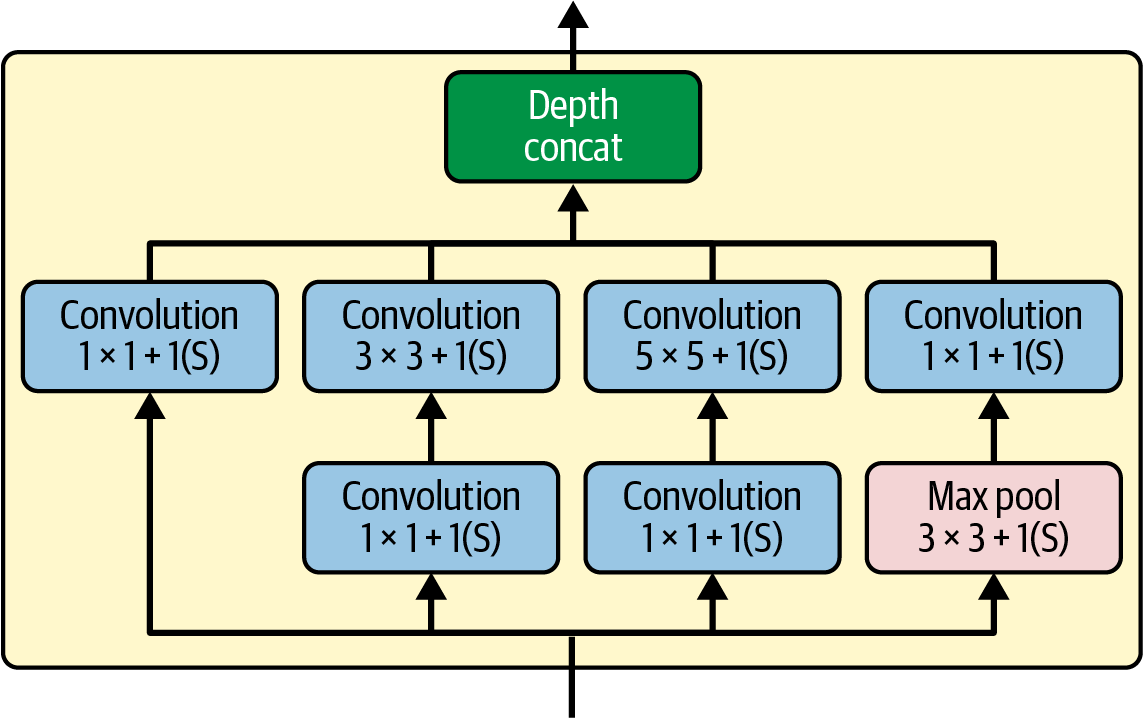

Inputs fed into 4 layers in parallel, letting it capture patterns at different scales

Then it concatenates all upper 4 conv layers outputs along the depth dimension 

(torch.cat(), w/ dim=1)

The 1x1 kernel layers exist to:
- Capture patterns in depth dimension (across channels)
- Output fewer feature maps than they take in
- Combine with bigger layers to act like a single layer

GoogLeNet uses NINE of these layers:
Input > Convolution > Max Pool > LRN > Convolution > Convolution > LRN > Max Pool > Inception > Inception > Max Pool > Inception > Inception > Inception > Inception > Inception > Max Pool > Inception > Inception > Global Avg Pool > 40% dropout > Fully connected layer > Softmax

What it did:
- First 2 layers divide img width, height by 4 each, using large kernels to keep info
- LRN ensures previous layers learn a lot of features
- Two convolution layers, first is 1x1, acts as a smart pair, then a LRN
- Max Pool to /2 and speed up 
- Nine inception modules with some max pools to reduce dimensionality + speed up
- Global avg pool outputs the mean of each feature map. This gets rid of any spatial info left. Since no fully connected layers, little overfit risk
- Dropout for reg, then 1000 classes predicted w/ fully connected layer



### ResNet

ResNet models go very very deep, with fewer parameters

Residual Learning: 
Neural nets try to model some target function h(x). But if you add the input x to your output, your model is forced to estimate h(x) - x. 

If you add a skip connection, the neural net now outputs x (close to x) at the start of training, and if h(x) is close to x you are starting pretty close to the answer!

If you add many skip connections, the network as a whole can make progress even if some layers "havent started learning". Your signal reaches the whole network


The ResNet Architecture: 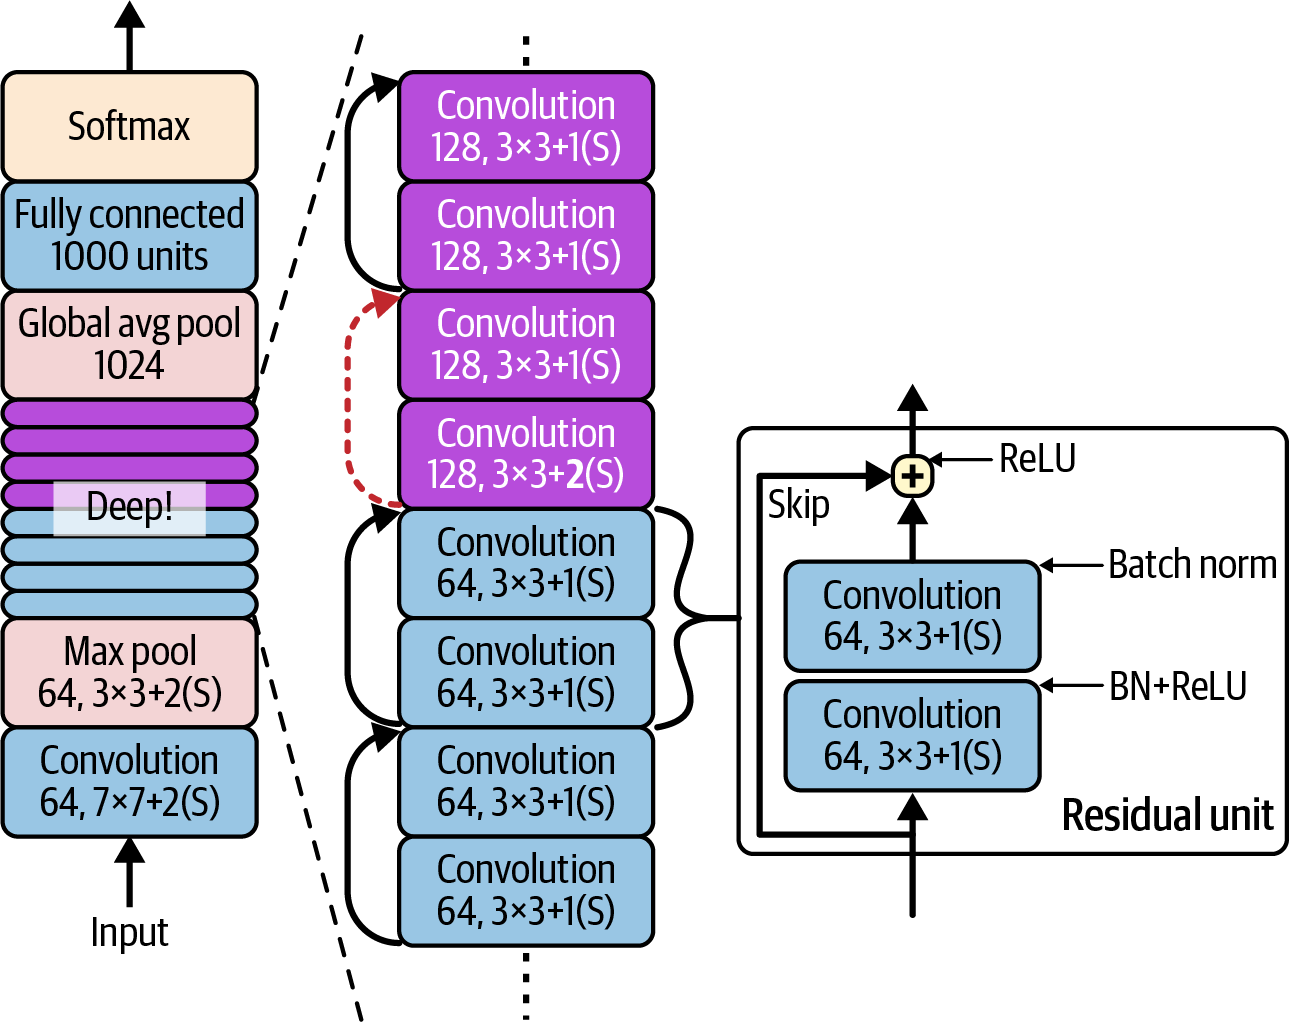

Note: feature maps get doubled every time a convolutional layer w/ stride 2 shows up, same number of total params. This causes problems because the inputs dim != output dim. Solution: pass inputs thru 1x1 convolution w/ stride 2.

ResNet 34 : 3 RU's w/ 64 maps, 4 w/ 128, 6 w/ 256, 3 w/ 512.

Deeper ResNet's will use a 1x1 convolutional layer w/ 64 feature maps, then a 3x3 w/ 64, then a 1x1 w/ 256 rather than two 3x3s w 256 

### Xception